Import libraries

In [0]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

Load annotations

In [0]:
annotations = '/content/labels_satellite-lakes_20200428105149.json'

In [0]:
data = pd.read_json(annotations)

In [0]:
data = data.transpose().reset_index()[['filename', 'regions']]

In [5]:
data.head()

,filename,regions
0,lake_001.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,lake_002.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,lake_003.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,lake_004.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,lake_005.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


In [6]:
data.shape

(108, 2)

Load images

In [0]:
directory = '/content/drive/My Drive/NWPU-RESISC45/lake'

In [8]:
images = []
for file in tqdm(sorted(os.listdir(directory))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']) and (file in data['filename']):
    print(file)
    image = tf.keras.preprocessing.image.load_img(directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images.append(image)

images = np.array(images)

In [9]:
images = []
to_import = data['filename']
for file in tqdm(to_import):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images.append(image)

images = np.array(images)

Function to plot images with annotations

In [0]:
def plot_image(i):
  #Image
  filename = data.iloc[i][0]
  image_1 = Image.open(directory + '/' + filename).convert('RGBA')

  #Polygon
  image_2 = image_1.copy()

  for shape in range(len(data['regions'][i])):
    x = data['regions'][i][str(shape)]['shape_attributes']['all_points_x']
    y = data['regions'][i][str(shape)]['shape_attributes']['all_points_y']
    coordinates = list(zip(x,y))
    draw = ImageDraw.Draw(image_2)
    draw.polygon(coordinates, fill='white')

  #Merge images
  final_image = Image.blend(image_1, image_2, alpha=0.75)
  return final_image

Masks

In [0]:
def create_mask(i):
  #Image
  filename = data.iloc[i][0]
  image_1 = Image.open(directory + '/' + filename)

  #Polygon
  image_2 = image_1.copy()
  draw = ImageDraw.Draw(image_2)
  draw.rectangle([(0,0),image_1.size], fill='black')

  for shape in range(len(data['regions'][i])):
    x = data['regions'][i][str(shape)]['shape_attributes']['all_points_x']
    y = data['regions'][i][str(shape)]['shape_attributes']['all_points_y']
    coordinates = list(zip(x,y))
    draw.polygon(coordinates, fill='white')

  #Merge images
  final_image = Image.blend(image_1, image_2, alpha=1)
  return final_image

Sample Images

In [0]:
i = np.random.randint(0,len(data))

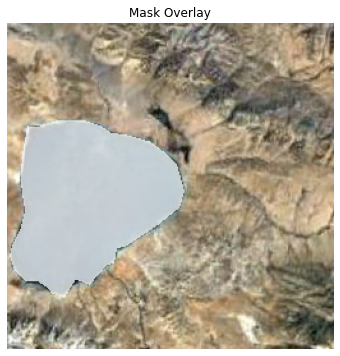

In [13]:
  plt.figure(figsize=(6,6))
  plt.imshow(plot_image(i))
  plt.title('Mask Overlay')
  plt.axis('off')
  plt.show()

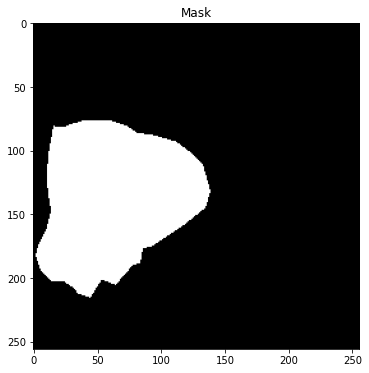

In [14]:
  plt.figure(figsize=(6,6))
  plt.imshow(create_mask(i))
  plt.title('Mask')
  plt.show()

Generate Masks

In [0]:
masks_directory = '/content/drive/My Drive/Lake - Masks'

In [16]:
for i in tqdm(range(0, len(data))):
  filename = data.iloc[i][0]
  image = create_mask(i)

  if image.mode in ("RGBA", "P"):
    image = image.convert("1")
  
  image.save(masks_directory + '/' + filename)

Load masks

In [17]:
masks = []
for file in tqdm(sorted(os.listdir(masks_directory))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(masks_directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    masks.append(image)

masks = np.array(masks)

In [18]:
masks.shape

(108, 256, 256, 3)

Image Generator

In [0]:
#def generator(images, batch_size, size):
#  masks = 


In [0]:
#train_generator = generator()
#test_generator = generator()

U-NET

In [0]:
image_width = 256
image_height = 256
image_channels = 3

In [0]:
inputs = Input(shape=(image_width, image_height, image_channels))
#1
first_convolution = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu' )(inputs)
first_convolution = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu' )(first_convolution)
first_pooling = MaxPooling2D(pool_size=(2,2))(first_convolution)
first_pooling = Dropout(0.5)(first_pooling)

#2
second_convolution = Conv2D(filters=2, kernel_size=(3,3), padding='same', activation='relu' )(first_pooling)
second_convolution = Conv2D(filters=2, kernel_size=(3,3), padding='same', activation='relu' )(second_convolution)
second_pooling = MaxPooling2D(pool_size=(2,2))(second_convolution)
second_pooling = Dropout(0.5)(second_pooling)

#3
third_convolution = Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu' )(second_pooling)
third_convolution = Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu' )(third_convolution)
third_pooling = MaxPooling2D(pool_size=(2,2))(third_convolution)
third_pooling = Dropout(0.5)(third_pooling)

#4
fourth_convolution = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu' )(third_pooling)
fourth_convolution = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu' )(fourth_convolution)
fourth_pooling = MaxPooling2D(pool_size=(2,2))(fourth_convolution)
fourth_pooling = Dropout(0.5)(fourth_pooling)

#5
fifth_convolution = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu' )(fourth_pooling)
fifth_convolution = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu' )(fifth_convolution)

#6
sixth_deconvolution = Conv2DTranspose(filters=8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(fifth_convolution)
sixth_convolution = concatenate([sixth_deconvolution, fourth_convolution])
sixth_convolution = Dropout(0.5)(sixth_convolution)
sixth_convolution = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)
sixth_convolution = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)


#7
seventh_deconvolution = Conv2DTranspose(filters=4, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(sixth_convolution)
seventh_convolution = concatenate([third_convolution, seventh_deconvolution])
seventh_convolution = Dropout(0.5)(seventh_convolution)
seventh_convolution = Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)
seventh_convolution = Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)

#8
eigth_deconvolution = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(seventh_convolution)
eigth_convolution = concatenate([eigth_deconvolution, second_convolution])
eigth_convolution = Dropout(0.5)(eigth_convolution)
eigth_convolution = Conv2D(filters=2, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)
eigth_convolution = Conv2D(filters=2, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)

#9
ninth_deconvolution = Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(eigth_convolution)
ninth_convolution = concatenate([ninth_deconvolution, first_convolution])
ninth_convolution = Dropout(0.5)(ninth_convolution)
ninth_convolution = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)
ninth_convolution = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)

#10
output = Conv2D(filters = 3, kernel_size=(1,1), padding='same', activation='sigmoid')(ninth_convolution)

In [0]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 1)  28          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 1)  10          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 1)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
#batch_size = 32
#train_steps = len(training_data) // batch_size
#test_steps = len(test_data) // batch_size

In [27]:
model.fit(images, masks, batch_size = 4, epochs = 5)

Epoch 1/5
27/27 [==============================] - 1s 21ms/step - loss: 0.6795 - mean_io_u: 0.3969
Epoch 2/5
27/27 [==============================] - 1s 23ms/step - loss: 0.6703 - mean_io_u: 0.3969
Epoch 3/5
27/27 [==============================] - 1s 20ms/step - loss: 0.6608 - mean_io_u: 0.3969
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 0.6501 - mean_io_u: 0.3969
Epoch 5/5
27/27 [==============================] - 1s 22ms/step - loss: 0.6384 - mean_io_u: 0.3969


In [0]:
predictions = model.predict(images)

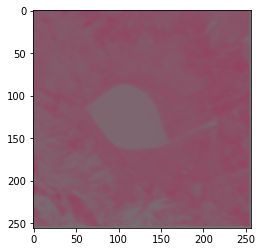

In [30]:
plt.imshow(predictions[0])